In [1]:
library(ggplot2)
library(boot)
library(glue)
library(dplyr)
library(tidyr)
library(parallel)
library(future.apply)
library(lmtest)
options(warn = -1)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: future

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [2]:
# Đường dẫn tới file hiện tại
base_path <- getwd()
setwd(base_path)
set.seed(23)
options(warn = -1) # Bỏ qua warning


In [3]:
# Dùng các hàm từ functions.R
source("functions.R")


## BÀI TẬP 1


### CÂU A


In [4]:
# Đặt các tham số
n <- 25
beta <- 0.5
sigma2 <- 4

# Tạo dữ liệu
set.seed(123)
X <- (1:n) / n
epsilon <- rnorm(n, mean = 0, sd = sqrt(sigma2))
Y <- beta * X + epsilon

# Tạo dataframe
df <- data.frame(X = X, Y = Y)

# Xây dựng mô hình hồi quy tuyến tính
model <- lm(Y ~ X - 1, data = df) # Không có hệ số chặn
summary(model)

# Tính phương sai của ước lượng beta
vcov_matrix <- vcov(model)
# Suy ra sai số chuẩn
se_beta <- sqrt(vcov_matrix)

# Tính khoảng tin cậy 90% cho hệ số beta
alpha <- 0.10
conf_interval <- confint(model, level = (1 - alpha))

print("Phuong sai cua uoc luong beta:")
print(se_beta)
print("KTC 90% cho beta:")
print(conf_interval)



Call:
lm(formula = Y ~ X - 1, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5106 -0.8942  0.0806  1.1068  3.9495 

Coefficients:
  Estimate Std. Error t value Pr(>|t|)
X -0.08702    0.62589  -0.139    0.891

Residual standard error: 1.861 on 24 degrees of freedom
Multiple R-squared:  0.0008048,	Adjusted R-squared:  -0.04083 
F-statistic: 0.01933 on 1 and 24 DF,  p-value: 0.8906


[1] "Phuong sai cua uoc luong beta:"
          X
X 0.6258851
[1] "KTC 90% cho beta:"
        5 %      95 %
X -1.157837 0.9837938


### CÂU B


In [5]:
# Viết hàm cho quá trình bootstrap
boot_fn <- function(data, indices) {
  d <- data[indices, ] # Lấy mẫu từ dữ liệu ban đầu
  model <- lm(Y ~ X - 1, data = d) # Xây dựng mô hình hồi quy tuyến tính
  return(coef(model)) # Trả về các hệ số hồi quy
}

# Thực hiện bootstrap với B = 1000 lần lặp
set.seed(123)
bootstrap_results <- boot(data = df, statistic = boot_fn, R = 1000)

# Tính toán sai số chuẩn của ước lượng beta
bootstrap_estimates <- bootstrap_results$t
se_bootstrap_beta <- sd(bootstrap_estimates)

# Tính khoảng tin cậy 90% cho hệ số hồi quy beta
conf_int_bootstrap <- quantile(bootstrap_estimates, c(0.05, 0.95))

print("Sai so chuan cua uoc luong beta tu bootstrap:")
print(se_bootstrap_beta)
print("KTC 90% cho beta tu bootstrap:")
print(conf_int_bootstrap)


[1] "Sai so chuan cua uoc luong beta tu bootstrap:"
[1] 0.5840868
[1] "KTC 90% cho beta tu bootstrap:"
        5%        95% 
-0.9736546  0.9445417 


- Khoảng tin cậy ở câu a: (-1.157837, 0.9837938)
- Khoảng tin cậy ở câu b: (-0.9736546, 0.9445417)
- Khoảng tin cậy thứ câu a rộng hơn so với khoảng tin cậy ở câu b, vì nó có biên dưới thấp hơn và biên trên cao hơn. Điều này có nghĩa là khoảng tin cậy ở câu a bao gồm nhiều giá trị hơn so với khoảng tin cậy ở câu b.


### CÂU C


In [6]:
M <- 5000
standard_errors <- numeric(M)
contains_true_beta <- numeric(M)

# Thực hiện mô phỏng Monte Carlo với 5000 lần lặp
set.seed(123)
for (i in 1:M) {
  # Tạo dữ liệu
  epsilon <- rnorm(n, mean = 0, sd = sqrt(sigma2))
  Y <- beta * X + epsilon
  df <- data.frame(X = X, Y = Y)

  # Xây dựng mô hình hồi quy tuyến tính
  model <- lm(Y ~ X - 1, data = df)

  # Tính phương sai của ước lượng beta
  vcov_matrix <- vcov(model)
  se_beta <- sqrt(vcov_matrix)

  # Tính khoảng tin cậy 90% cho hệ số beta
  conf_interval <- confint(model, level = (1 - alpha))
  # Lưu trữ sai số chuẩn và kết quả khoảng tin cậy
  standard_errors[i] <- se_beta
  contains_true_beta[i] <- (conf_interval[1] <= beta) & (conf_interval[2] >= beta)
}

# Tính trung bình của 5000 sai số chuẩn
mean_standard_error <- mean(standard_errors)

# Tính xác suất phủ của 5000 khoảng tin cậy
coverage_probability <- mean(contains_true_beta)

print("Trung binh cua 5000 sai so chuan:")
print(mean_standard_error)
print("Xac suat phu cua 5000 KTC:")
print(coverage_probability)


[1] "Trung binh cua 5000 sai so chuan:"
[1] 0.6655876
[1] "Xac suat phu cua 5000 KTC:"
[1] 0.906


### CÂU D


In [7]:
M = 5000
standard_errors_bootstrap <- numeric(M)
contains_true_beta_bootstrap <- numeric(M)

# Thực hiện mô phỏng Monte Carlo với 5000 lần lặp
set.seed(123)
for (i in 1:M) {
  # Tạo dữ liệu
  epsilon <- rnorm(n, mean = 0, sd = sqrt(sigma2))
  Y <- beta * X + epsilon
  df <- data.frame(X = X, Y = Y)

  # Thực hiện bootstrap với B = 1000 lần lặp
  bootstrap_results <- boot(data = df, statistic = boot_fn, R = 1000)

  # Tính toán sai số chuẩn của ước lượng beta
  bootstrap_estimates <- bootstrap_results$t
  se_bootstrap_beta <- sd(bootstrap_estimates)

  # Tính khoảng tin cậy 90% cho hệ số hồi quy beta
  conf_int_bootstrap <- quantile(bootstrap_estimates, c(0.05, 0.95))

  # Lưu trữ sai số chuẩn và kết quả khoảng tin cậy
  standard_errors_bootstrap[i] <- se_bootstrap_beta
  contains_true_beta_bootstrap[i] <- (conf_int_bootstrap[1] <= beta) & (conf_int_bootstrap[2] >= beta)
}

# Tính trung bình của 5000 sai số chuẩn
mean_standard_error_bootstrap <- mean(standard_errors_bootstrap)

# Tính xác suất phủ của 5000 khoảng tin cậy
coverage_probability_bootstrap <- mean(contains_true_beta_bootstrap)

print("Trung binh cua 5000 sai so chuan tu bootstrap:")
print(mean_standard_error_bootstrap)
print("Xac suat phu cua 5000 KTC tu bootstrap:")
print(coverage_probability_bootstrap)


[1] "Trung binh cua 5000 sai so chuan tu bootstrap:"
[1] 0.5914953
[1] "Xac suat phu cua 5000 KTC tu bootstrap:"
[1] 0.8


## BÀI TẬP 2


### CÂU A

$$H_0: \beta = 0$$
$$H_1: \beta \ 0$$


In [8]:
# Đặt các tham số
n <- 25
beta <- 0.5
sigma2 <- 4

# Tạo dữ liệu
set.seed(123)
X <- (1:n) / n
epsilon <- rnorm(n, mean = 0, sd = sqrt(sigma2))
Y <- beta * X + epsilon

# Tạo dataframe
df <- data.frame(X = X, Y = Y)
head(df)


,X,Y
,<dbl>,<dbl>
1,0.04,-1.1009513
2,0.08,-0.4203550
3,0.12,3.1774166
4,0.16,0.2210168
5,0.20,0.3585755
6,0.24,3.5501300


In [9]:
# Hàm thống kê kiểm định theo hiệu số để thực hiện bootstrap
one_mean_test_diff <- function(data, ind, beta) {
  data_new <- data[ind, ]
  model <- lm(Y ~ X, data = data_new)
  beta_boot <- coef(model)[2] # Hệ số beta
  t_stat <- beta_boot - beta
  return(t_stat)
}


In [10]:
# Tính thống kê kiểm định trên dữ liệu gốc
t_obs <- one_mean_test_diff(
    data = df,
    ind = c(1:nrow(df)), beta = 0
)
t_obs


X 
-1.578214

In [11]:
# Thực hiện bootstrap
mean_beta <- mean(beta) # beta trong dữ liệu gốc là 0.5
out_boot <- boot(
    data = df,
    statistic = one_mean_test_diff, R = 1000,
    beta = mean_beta
)
out_boot



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = one_mean_test_diff, R = 1000, beta = mean_beta)


Bootstrap Statistics :
     original      bias    std. error
t1* -2.078214 0.006071808    1.135886

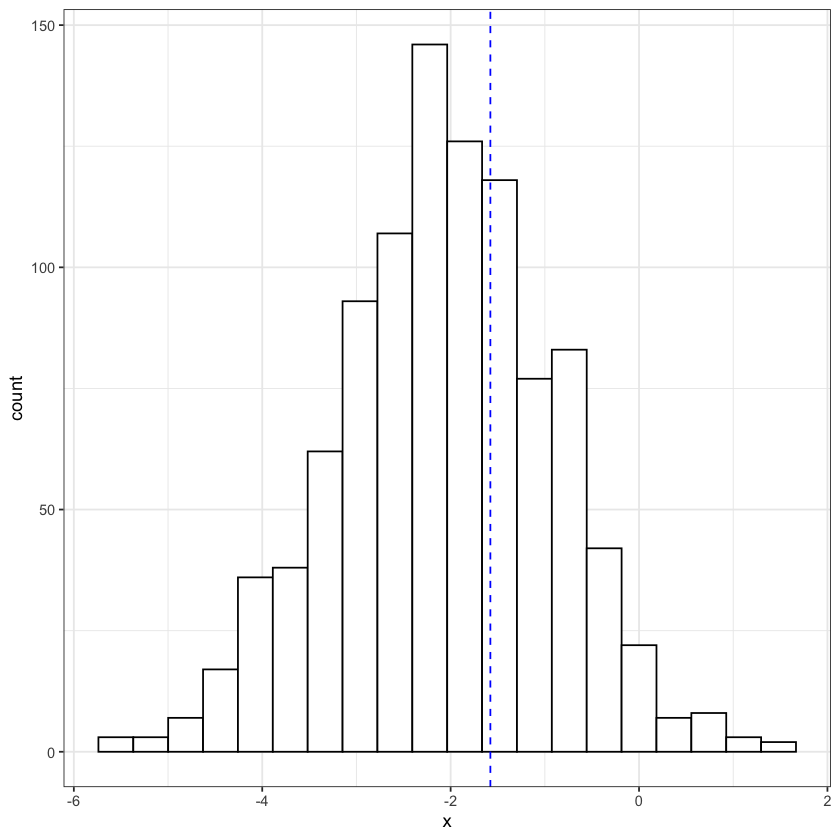

In [12]:
ggplot(data = data.frame(x = out_boot$t), mapping = aes(x = x)) +
    geom_histogram(bins = 20, fill = "white", color = "black") +
    geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
    theme_bw()


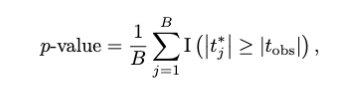


In [13]:
p_value <- mean(abs(out_boot$t) >= abs(t_obs))
p_value


[1] 0.676

- Với p-value = 0.6704 > alpha = 0.05, do đó ta chưa đủ bằng chứng để bác bỏ giả thiết H0 rằng $\beta = 0$


### CÂU B

$$H_0: \beta \le 0$$
$$H_1: \beta \gt 0$$


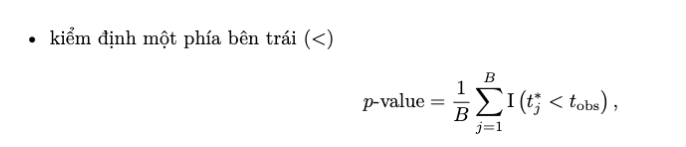


In [14]:
# Tính thống kê kiểm định trên dữ liệu gốc
t_obs <- one_mean_test_diff(
    data = df,
    ind = c(1:nrow(df)), beta = 0.4
)
t_obs


X 
-1.978214

In [15]:
# Thực hiện bootstrap (giống với câu a)
mean_beta <- mean(beta) # beta trong dữ liệu gốc là 0.5
out_boot <- boot(
    data = df,
    statistic = one_mean_test_diff, R = 1000,
    beta = mean_beta
)
out_boot



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = one_mean_test_diff, R = 1000, beta = mean_beta)


Bootstrap Statistics :
     original     bias    std. error
t1* -2.078214 0.03266065    1.115785

In [16]:
p_value <- mean(abs(out_boot$t) < abs(t_obs))
p_value


[1] 0.475

- Với p-value = 0.465 > alpha = 0.05, do đó ta chưa đủ bằng chứng để bác bỏ giả thiết H0 rằng $\beta \le 0.4$


### CÂU C


In [17]:
M <- 5000
p_value_bootstrap <- numeric(M)
for (i in 1:M) { # Thực hiện bootstrap
    mean_beta <- mean(beta) # beta trong dữ liệu gốc là 0.5
    out_boot <- boot(
        data = df,
        statistic = one_mean_test_diff, R = 1000,
        beta = mean_beta
    )
    # out_boot
    p_value <- mean(abs(out_boot$t) >= abs(t_obs))
    p_value_bootstrap[i] <- p_value
}


In [18]:
sai_lam_loai_1 <- function(p_value_bootstrap, alpha) {
    num_significant <- sum(p_value_bootstrap <= alpha)
    # Tính tỷ lệ p-value nhỏ hơn hoặc bằng alpha
    type1_error_rate <- num_significant / length(p_value_bootstrap)
    return(type1_error_rate)
}


In [ ]:
for (ap in c(0.1, 0.05, 0.01)) {
    rate <- sai_lam_loai_1(p_value_bootstrap, ap)
    cat(sprintf("Xac suat mac sai lam loai 1 voi alpha = %.2f: %.3f\n", ap, rate))
}


In [ ]:
hist(p_value_bootstrap, breaks = 50, main = "Histogram cua 5000 p-value", xlab = "p-value", col = "skyblue", border = "black")


### CÂU D


In [21]:
M <- 5000
p_value_bootstrap <- numeric(M)
for (i in 1:M) { # Thực hiện bootstrap
    mean_beta <- mean(beta) # beta trong dữ liệu gốc là 0.5
    out_boot <- boot(
        data = df,
        statistic = one_mean_test_diff, R = 1000,
        beta = mean_beta
    )
    out_boot
    p_value <- mean(abs(out_boot$t) < abs(t_obs))
    p_value_bootstrap[i] <- p_value
}


In [ ]:
for (ap in c(0.1, 0.05, 0.01)) {
    rate <- sai_lam_loai_1(p_value_bootstrap, ap)
    cat(sprintf("Xac suat mac sai lam loai 1 voi alpha = %.2f: %.3f\n", ap, rate))
}


In [ ]:
hist(p_value_bootstrap, breaks = 50, main = "Histogram cua 5000 p-value", xlab = "p-value", col = "skyblue", border = "black")


## BÀI TẬP 3


### CÂU A


In [24]:
# Đặt các tham số
n <- 25
beta <- 0.5
sigma_squared <- 4


In [25]:
# Tạo dữ liệu
set.seed(123)
delta <- rnorm(n, mean = 0, sd = sqrt(sigma2))
X <- (1:n) / n
epsilon <- X * delta
Y <- beta * X + epsilon
df <- data.frame(X = X, Y = Y)
head(df)


,X,Y
,<dbl>,<dbl>
1,0.04,-0.024838052
2,0.08,0.003171602
3,0.12,0.434089995
4,0.16,0.102562685
5,0.20,0.151715094
6,0.24,0.943231194


In [26]:
# Xây dựng mô hình hồi quy tuyến tính
model <- lm(Y ~ X - 1, data = df) # Không có hệ số chặn
# summary(model)
# Tính phương sai của ước lượng beta
vcov_matrix <- vcov(model)
# Suy ra sai số chuẩn
se_beta <- sqrt(vcov_matrix)
# KTC xấp xỉ chuẩn
KTC <- boot.ci(out_boot, conf = 0.9, type = "norm")
# # Tính khoảng tin cậy 90% cho hệ số beta
# alpha <- 0.10
# conf_interval = confint(model, level = (1-alpha))

print("Phuong sai cua uoc luong beta:")
print(se_beta)
print("KTC 90% cho beta:")
print(KTC)


[1] "Phuong sai cua uoc luong beta:"
          X
X 0.3492346
[1] "KTC 90% cho beta:"
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = out_boot, conf = 0.9, type = "norm")

Intervals : 
Level      Normal        
90%   (-3.942, -0.158 )  
Calculations and Intervals on Original Scale


### CÂU B


In [27]:
wild_bootstrap <- function(data, indices) {
  d <- data[indices, ]
  fit <- lm(Y ~ X - 1, data = d)
  residuals <- resid(fit)
  fitted <- fitted(fit)
  u <- sample(c(-1, 1), n, replace = TRUE)
  Y_star <- fitted + u * residuals
  d$Y_star <- Y_star
  fit_star <- lm(Y_star ~ X - 1, data = d)
  return(coef(fit_star))
}


In [28]:
# Perform wild bootstrap
set.seed(123)
B <- 1000
out_boot <- boot(data = df, statistic = wild_bootstrap, R = B)
out_boot



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = wild_bootstrap, R = B)


Bootstrap Statistics :
     original     bias    std. error
t1* 0.1082836 -0.2493852   0.5656814

In [29]:
bootstrap_se <- sd(out_boot$t)
bootstrap_se


[1] 0.5656814

In [30]:
KTC <- boot.ci(out_boot, type = "norm", conf = 0.90)
KTC


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = out_boot, conf = 0.9, type = "norm")

Intervals : 
Level      Normal        
90%   (-0.5728,  1.2881 )  
Calculations and Intervals on Original Scale

### CÂU C


In [31]:
# set.seed(123)
M <- 5000
standard_errors <- numeric(M)
contains_true_beta <- numeric(M)

# Thực hiện mô phỏng Monte Carlo với 5000 lần lặp
for (i in 1:M) {
  # Tạo dữ liệu
  delta <- rnorm(n, mean = 0, sd = sqrt(sigma2))
  X <- (1:n) / n
  epsilon <- X * delta
  Y <- beta * X + epsilon
  df <- data.frame(X = X, Y = Y)

  # Xây dựng mô hình hồi quy tuyến tính
  model <- lm(Y ~ X - 1, data = df)

  # Tính phương sai của ước lượng beta
  vcov_matrix <- vcov(model)
  se_beta <- sqrt(vcov_matrix)

  # Tính khoảng tin cậy 90% cho hệ số beta
  conf_interval <- confint(model, level = (1 - alpha))
  # Lưu trữ sai số chuẩn và kết quả khoảng tin cậy
  standard_errors[i] <- se_beta
  contains_true_beta[i] <- (conf_interval[1] <= beta) & (conf_interval[2] >= beta)
}

# Tính trung bình của 5000 sai số chuẩn
mean_standard_error <- mean(standard_errors)

# Tính xác suất phủ của 5000 khoảng tin cậy
coverage_probability <- mean(contains_true_beta)

print("Trung binh cua 5000 sai so chuan:")
print(mean_standard_error)
print("Xac suat phu cua 5000 KTC:")
print(coverage_probability)


[1] "Trung binh cua 5000 sai so chuan:"
[1] 0.3866994
[1] "Xac suat phu cua 5000 KTC:"
[1] 0.7718


### CÂU D


In [32]:
standard_errors_bootstrap <- numeric(M)
contains_true_beta_bootstrap <- numeric(M)
M <- 5000
# Thực hiện mô phỏng Monte Carlo với 5000 lần lặp
set.seed(123)
for (i in 1:M) {
  # # Tạo dữ liệu
  # delta = rnorm(n, mean = 0, sd = sqrt(sigma2))
  # X <- (1:n) / n
  # epsilon = X * delta
  # Y <- beta * X + epsilon
  # df <- data.frame(X = X, Y = Y)

  # Thực hiện bootstrap với B = 1000 lần lặp (dùng lại hàm ở câu b)
  bootstrap_results <- boot(data = df, statistic = wild_bootstrap, R = 1000)

  # Tính toán sai số chuẩn của ước lượng beta
  bootstrap_estimates <- bootstrap_results$t
  se_bootstrap_beta <- sd(bootstrap_estimates)

  # Tính khoảng tin cậy 90% cho hệ số hồi quy beta
  conf_int_bootstrap <- quantile(bootstrap_estimates, c(0.05, 0.95))

  # Lưu trữ sai số chuẩn và kết quả khoảng tin cậy
  standard_errors_bootstrap[i] <- se_bootstrap_beta
  contains_true_beta_bootstrap[i] <- (conf_int_bootstrap[1] <= beta) & (conf_int_bootstrap[2] >= beta)
}

# Tính trung bình của 5000 sai số chuẩn
mean_standard_error_bootstrap <- mean(standard_errors_bootstrap)

# Tính xác suất phủ của 5000 khoảng tin cậy
coverage_probability_bootstrap <- mean(contains_true_beta_bootstrap)

print("Trung binh cua 5000 sai so chuan tu bootstrap:")
print(mean_standard_error_bootstrap)
print("Xac suat phu cua 5000 KTC tu bootstrap:")
print(coverage_probability_bootstrap)


[1] "Trung binh cua 5000 sai so chuan tu bootstrap:"
[1] 0.0003817314
[1] "Xac suat phu cua 5000 KTC tu bootstrap:"
[1] 0.001


## BÀI TẬP 4


### CÂU A


In [33]:
# Thiết lập các tham số
set.seed(123)
n <- 100
beta_0 <- 10
beta_1 <- 5


In [34]:
# Tạo dữ liệu ban đầu
X <- sample(1:20, n, replace = TRUE)
epsilon <- rnorm(n, mean = 0, sd = 1)
Y <- beta_0 + beta_1 * X + epsilon
# Tạo dataframe
df <- data.frame(X = X, Y = Y)
head(df)


,X,Y
,<int>,<dbl>
1,15,85.33178
2,19,106.09684
3,14,80.43518
4,3,24.67407
5,10,61.14881
6,18,100.99350


In [35]:
# Xây dựng mô hình
model <- lm(Y ~ X, data = df)
summary(model)



Call:
lm(formula = Y ~ X, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9720 -0.6934 -0.0688  0.5742  3.2451 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.76434    0.23040   42.38   <2e-16 ***
X            5.01930    0.01888  265.88   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9862 on 98 degrees of freedom
Multiple R-squared:  0.9986,	Adjusted R-squared:  0.9986 
F-statistic: 7.069e+04 on 1 and 98 DF,  p-value: < 2.2e-16


In [36]:
# Sai số
residuals <- residuals(model)
# residuals


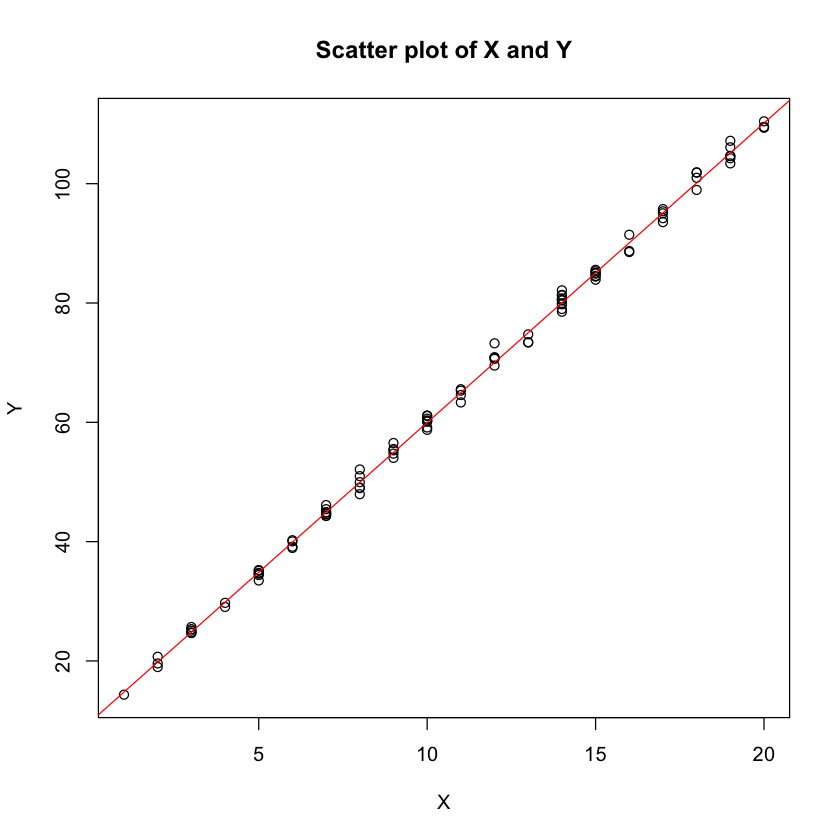

In [37]:
plot(X, Y, main = "Scatter plot of X and Y", xlab = "X", ylab = "Y")
abline(model, col = "red")


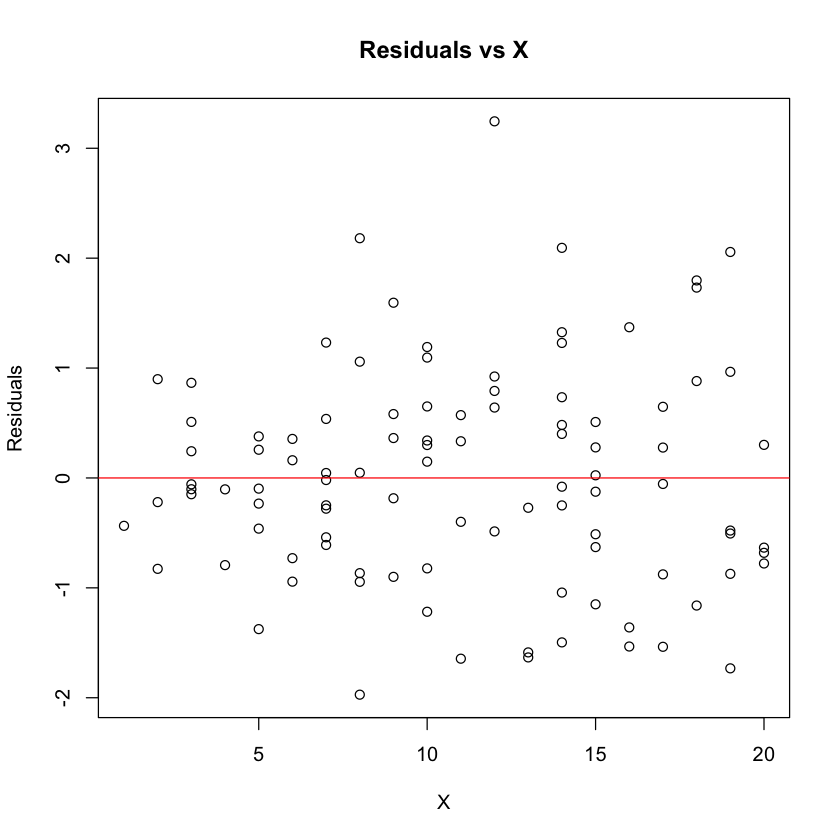

In [38]:
plot(X, residuals, main = "Residuals vs X", xlab = "X", ylab = "Residuals")
abline(h = 0, col = "red")


In [39]:
model$coefficients


(Intercept)           X 
   9.764336    5.019301

### CÂU B


In [40]:
# Hàm tạo mẫu bootstrap
bootstrap_function <- function(data, indices) {
  # Lấy mẫu dựa trên chỉ số
  data_new <- data[indices, ]

  # Xây dựng mô hình hồi quy
  model <- lm(Y ~ X, data = data_new)

  # Trả về hệ số beta ước lượng
  return(coef(model))
}


In [41]:
out_boot <- boot(data = df, statistic = bootstrap_function, R = 1000)
out_boot



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = bootstrap_function, R = 1000)


Bootstrap Statistics :
    original        bias    std. error
t1* 9.764336 -0.0049208139  0.17268080
t2* 5.019301  0.0002793031  0.01650844

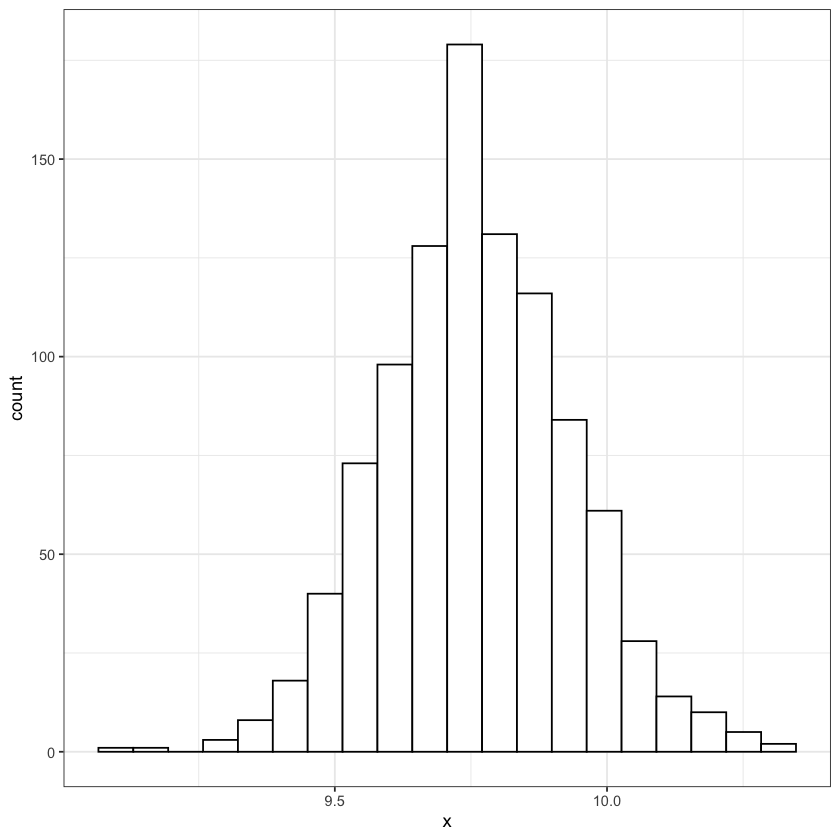

In [42]:
ggplot(data = data.frame(x = out_boot$t[, 1]), mapping = aes(x = x)) +
    geom_histogram(bins = 20, fill = "white", color = "black") +
    # geom_vline(xintercept = t_obs, linetype = "dashed", color = "blue") +
    theme_bw()


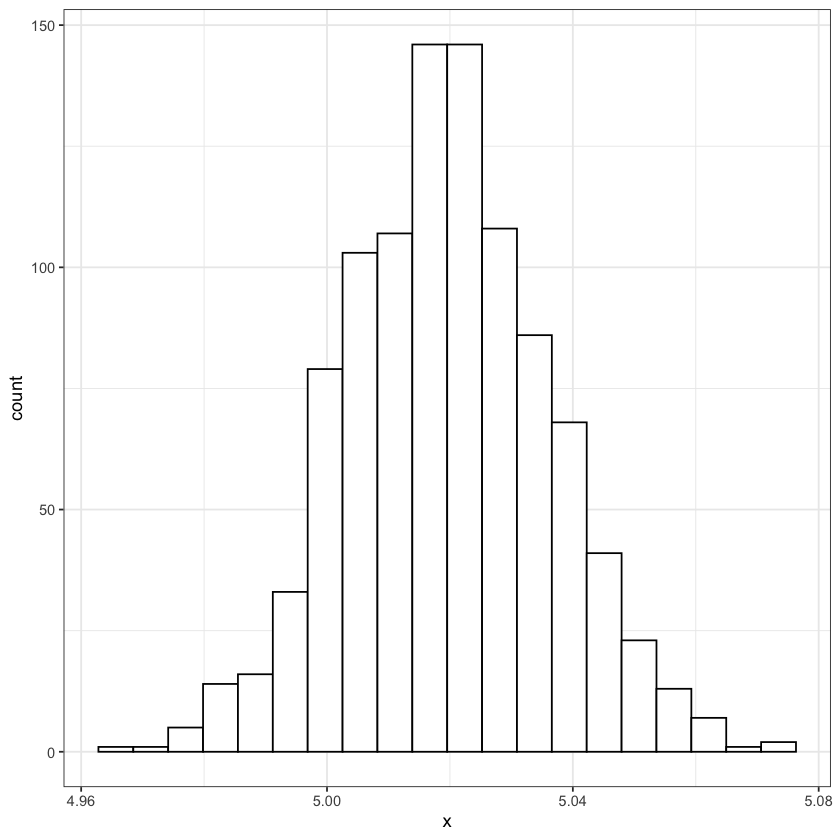

In [43]:
ggplot(data = data.frame(x = out_boot$t[, 2]), mapping = aes(x = x)) +
    geom_histogram(bins = 20, fill = "white", color = "black") +
    theme_bw()


In [44]:
# Tính sai số chuẩn
sd(out_boot$t[, 1])
sd(out_boot$t[, 2])


[1] 0.1726808

[1] 0.01650844

In [45]:
KTC <- boot.ci(out_boot, conf = 0.9, type = "all")
KTC


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = out_boot, conf = 0.9, type = "all")

Intervals : 
Level      Normal              Basic             Studentized     
90%   ( 9.485, 10.053 )   ( 9.484, 10.046 )   ( 9.483, 10.045 )  

Level     Percentile            BCa          
90%   ( 9.483, 10.045 )   ( 9.507, 10.071 )  
Calculations and Intervals on Original Scale

### CÂU C


In [46]:
wild_bootstrap <- function(data, indices) {
  d <- data[indices, ]
  fit <- lm(Y ~ X, data = d)
  residuals <- resid(fit)
  fitted <- fitted(fit)
  u <- sample(c(-1, 1), n, replace = TRUE)
  Y_star <- fitted + u * residuals
  d$Y_star <- Y_star
  fit_star <- lm(Y_star ~ X, data = d)
  return(coef(fit_star))
}


In [47]:
out_boot <- boot(data = df, statistic = wild_bootstrap, R = 1000)
out_boot



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = wild_bootstrap, R = 1000)


Bootstrap Statistics :
    original      bias    std. error
t1* 9.595220  0.16711171  0.26214909
t2* 5.032858 -0.01330873  0.02482468

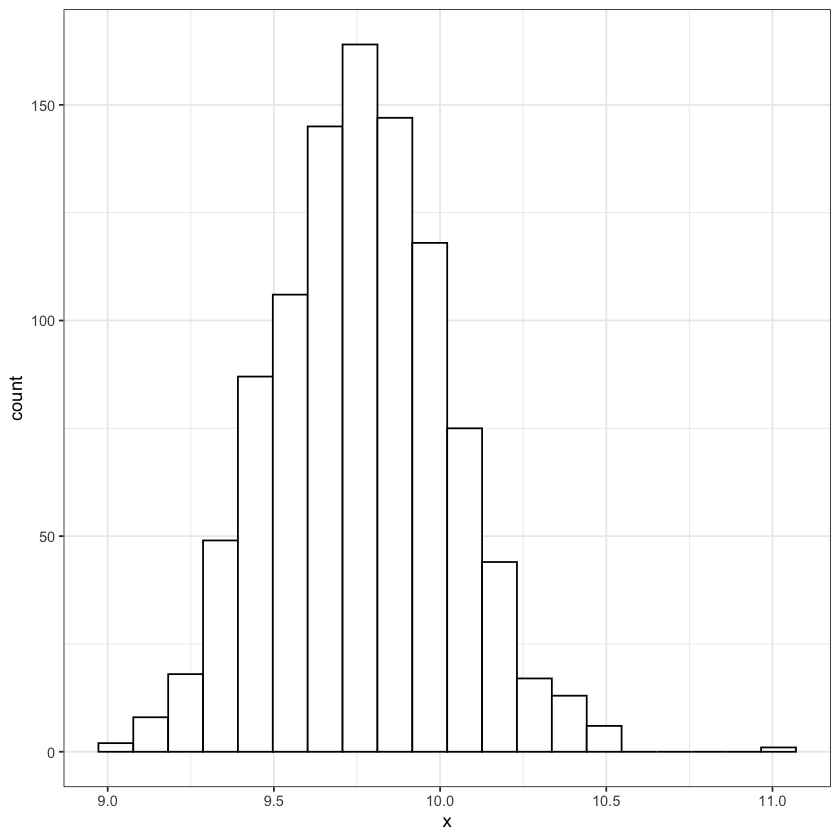

In [48]:
ggplot(data = data.frame(x = out_boot$t[, 1]), mapping = aes(x = x)) +
    geom_histogram(bins = 20, fill = "white", color = "black") +
    theme_bw()


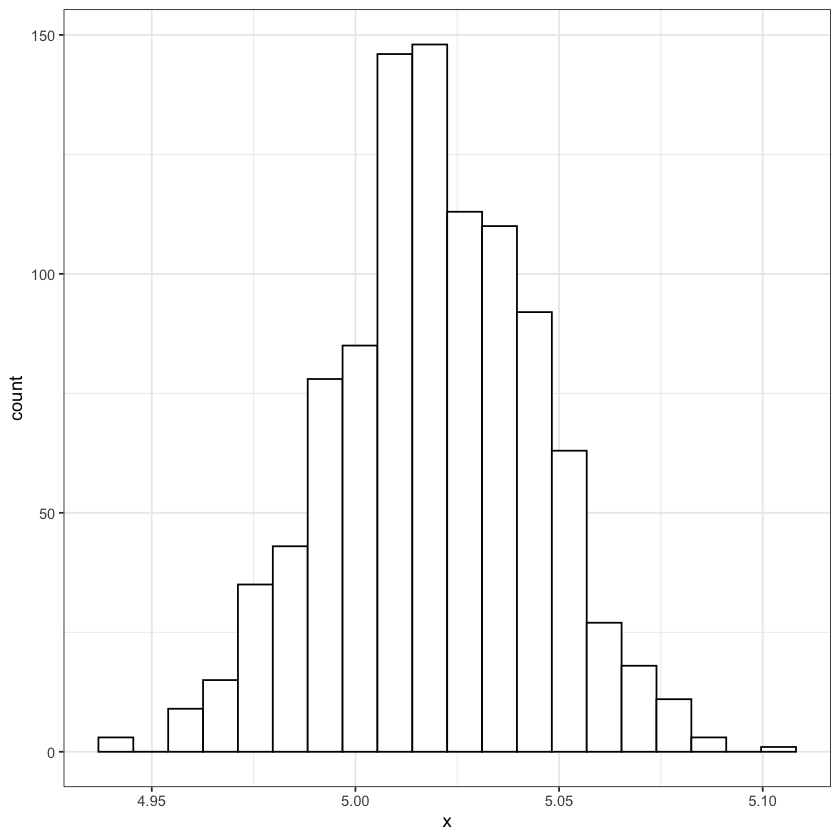

In [49]:
ggplot(data = data.frame(x = out_boot$t[, 2]), mapping = aes(x = x)) +
    geom_histogram(bins = 20, fill = "white", color = "black") +
    theme_bw()


In [50]:
# Tính sai số chuẩn
sd(out_boot$t[, 1])
sd(out_boot$t[, 2])


[1] 0.2621491

[1] 0.02482468

In [51]:
KTC <- boot.ci(out_boot, conf = 0.9, type = "all")
KTC


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = out_boot, conf = 0.9, type = "all")

Intervals : 
Level      Normal              Basic             Studentized     
90%   ( 8.997,  9.859 )   ( 8.998,  9.845 )   ( 8.996,  9.844 )  

Level     Percentile            BCa          
90%   ( 9.346, 10.193 )   ( 9.043,  9.854 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable

### CÂU D


- Khoảng tin cậy ở câu b cho thấy giá trị trung bình được ước tính cao hơn ở tất cả các loại khoảng tin cậy.
- Khoảng tin cậy ở câu c rộng hơn trong trường hợp của Percentile Intervals, nhưng hẹp hơn trong các trường hợp còn lại.


## BÀI TẬp 5


In [52]:
df <- read_csv_function(base_path = base_path, file_name = "Advertising.csv")
head(df)


,id,TV,radio,newspaper,sales
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,230.1,37.8,69.2,22.1
2,2,44.5,39.3,45.1,10.4
3,3,17.2,45.9,69.3,9.3
4,4,151.5,41.3,58.5,18.5
5,5,180.8,10.8,58.4,12.9
6,6,8.7,48.9,75.0,7.2


### CÂU A


In [53]:
model <- lm(sales ~ TV, data = df)
summary(model)



Call:
lm(formula = sales ~ TV, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3860 -1.9545 -0.1913  2.0671  7.2124 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.032594   0.457843   15.36   <2e-16 ***
TV          0.047537   0.002691   17.67   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.259 on 198 degrees of freedom
Multiple R-squared:  0.6119,	Adjusted R-squared:  0.6099 
F-statistic: 312.1 on 1 and 198 DF,  p-value: < 2.2e-16


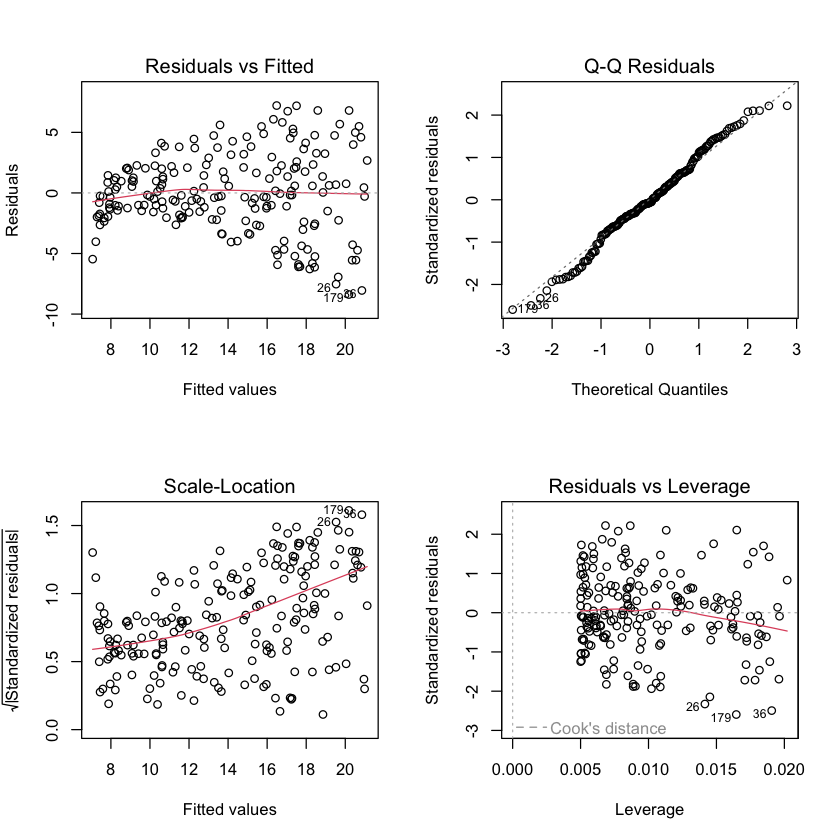

In [54]:
# Plot residuals
par(mfrow = c(2, 2))
plot(model)


In [55]:
# Thực hiện Shapiro-Wilk test
shapiro.test(model$residuals)



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.99053, p-value = 0.2133


- Giả định về phân phối chuẩn của thặng dư: Với giá trị W gần 1 và giá trị p cao, có thể kết luận rằng thặng dư của mô hình hồi quy tuyến tính có khả năng tuân theo phân phối chuẩn.


In [56]:
# Kiểm tra sự tự tương quan (autocorrelation) của các thặng dư (residuals)
dw_test <- dwtest(model)
dw_test



	Durbin-Watson test

data:  model
DW = 1.9347, p-value = 0.3213
alternative hypothesis: true autocorrelation is greater than 0


- Không có bằng chứng mạnh mẽ về tự tương quan trong các thặng dư: Với giá trị DW gần 2 và giá trị p cao, có thể kết luận rằng các thặng dư của mô hình hồi quy tuyến tính không có tự tương quan dương đáng kể.


In [57]:
bp_test <- bptest(model)
bp_test



	studentized Breusch-Pagan test

data:  model
BP = 48.038, df = 1, p-value = 4.18e-12


- Có sự không đồng nhất phương sai (heteroscedasticity): Với giá trị p rất nhỏ (4.18e-12), có thể kết luận rằng phương sai của các thặng dư không đồng nhất. Điều này vi phạm giả định của mô hình hồi quy tuyến tính


### CÂU B


- Với vấn đề không đồng nhất phương sai ở câu a, ta có thể áp dụng quy trình wild bootstrap sẽ thích hợp cho trường hợp này


In [58]:
wild_bootstrap <- function(data, indices) {
    d <- data[indices, ]
    fit <- lm(sales ~ TV, data = d)
    residuals <- resid(fit)
    fitted <- fitted(fit)
    u <- sample(c(-1, 1), n, replace = TRUE)
    Y_star <- fitted + u * residuals
    d$Y_star <- Y_star
    fit_star <- lm(Y_star ~ TV, data = d)
    return(coef(fit_star))
}


In [59]:
out_boot <- boot(data = df, statistic = wild_bootstrap, R = 1000)
out_boot



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df, statistic = wild_bootstrap, R = 1000)


Bootstrap Statistics :
      original       bias    std. error
t1* 7.28149763 -0.270901501 0.467042299
t2* 0.04497865  0.002783332 0.003956586

In [60]:
# Tính sai số chuẩn
sd(out_boot$t[, 1])
sd(out_boot$t[, 2])


[1] 0.4670423

[1] 0.003956586

In [61]:
# Khoảng tin cậy
KTC <- boot.ci(out_boot, conf = 0.9, type = "all")
KTC


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = out_boot, conf = 0.9, type = "all")

Intervals : 
Level      Normal              Basic             Studentized     
90%   ( 6.784,  8.321 )   ( 6.767,  8.325 )   ( 6.753,  8.232 )  

Level     Percentile            BCa          
90%   ( 6.238,  7.796 )   ( 6.767,  8.259 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable

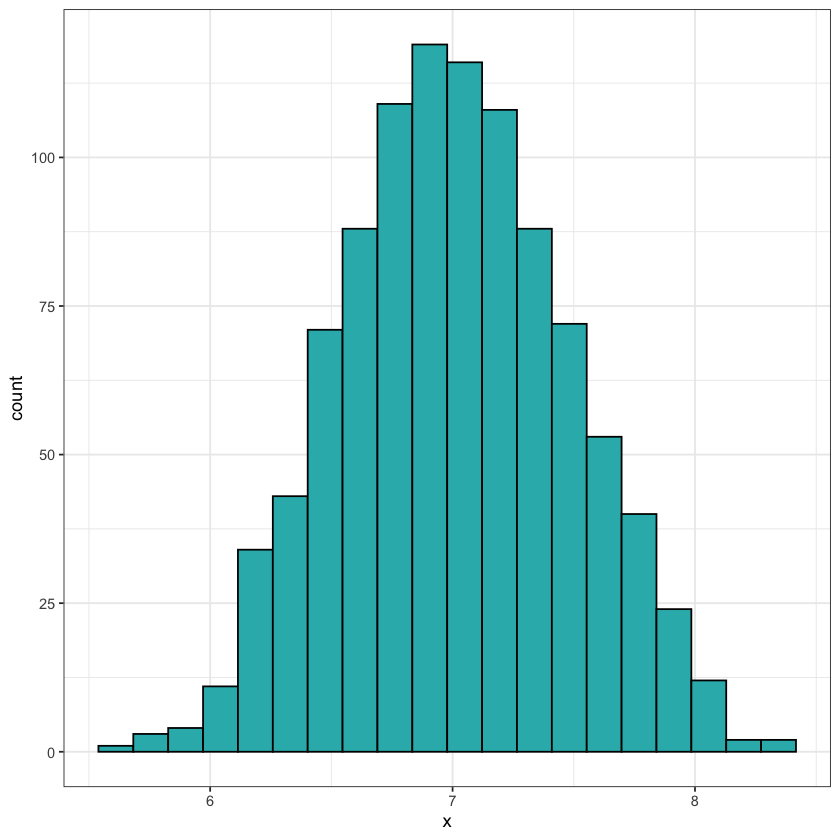

In [62]:
ggplot(data = data.frame(x = out_boot$t[, 1]), mapping = aes(x = x)) +
    geom_histogram(bins = 20, fill = "#2eb6b9", color = "#000000") +
    theme_bw()


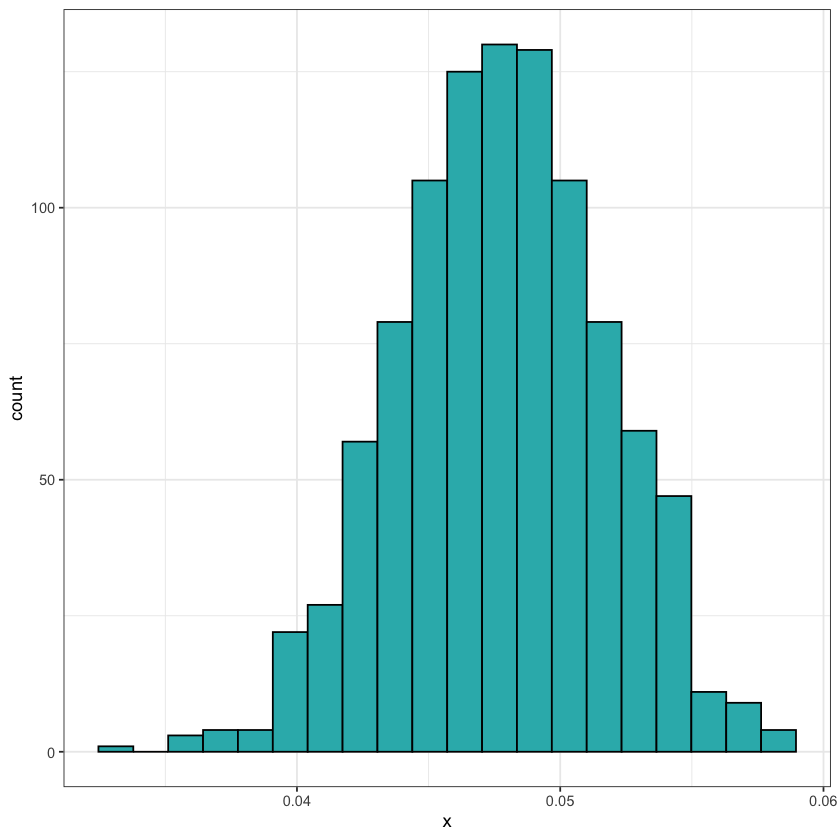

In [63]:
ggplot(data = data.frame(x = out_boot$t[, 2]), mapping = aes(x = x)) +
    geom_histogram(bins = 20, fill = "#2eb6b9", color = "black") +
    theme_bw()


## BÀI TẬP 6


In [64]:
lynx


A Time Series:
  [1]  269  321  585  871 1475 2821 3928 5943 4950 2577  523   98  184  279  409
 [16] 2285 2685 3409 1824  409  151   45   68  213  546 1033 2129 2536  957  361
 [31]  377  225  360  731 1638 2725 2871 2119  684  299  236  245  552 1623 3311
 [46] 6721 4254  687  255  473  358  784 1594 1676 2251 1426  756  299  201  229
 [61]  469  736 2042 2811 4431 2511  389   73   39   49   59  188  377 1292 4031
 [76] 3495  587  105  153  387  758 1307 3465 6991 6313 3794 1836  345  382  808
 [91] 1388 2713 3800 3091 2985 3790  674   81   80  108  229  399 1132 2432 3574
[106] 2935 1537  529  485  662 1000 1590 2657 3396

In [65]:
nam <- 1821:1934
lynx <- window(lynx, start = 1821, end = 1934)
# Tạo DataFrame
df <- data.frame(nam = nam, lynx = as.numeric(lynx))
head(df)
tail(df)


,nam,lynx
,<int>,<dbl>
1,1821,269
2,1822,321
3,1823,585
4,1824,871
5,1825,1475
6,1826,2821


,nam,lynx
,<int>,<dbl>
109,1929,485
110,1930,662
111,1931,1000
112,1932,1590
113,1933,2657
114,1934,3396


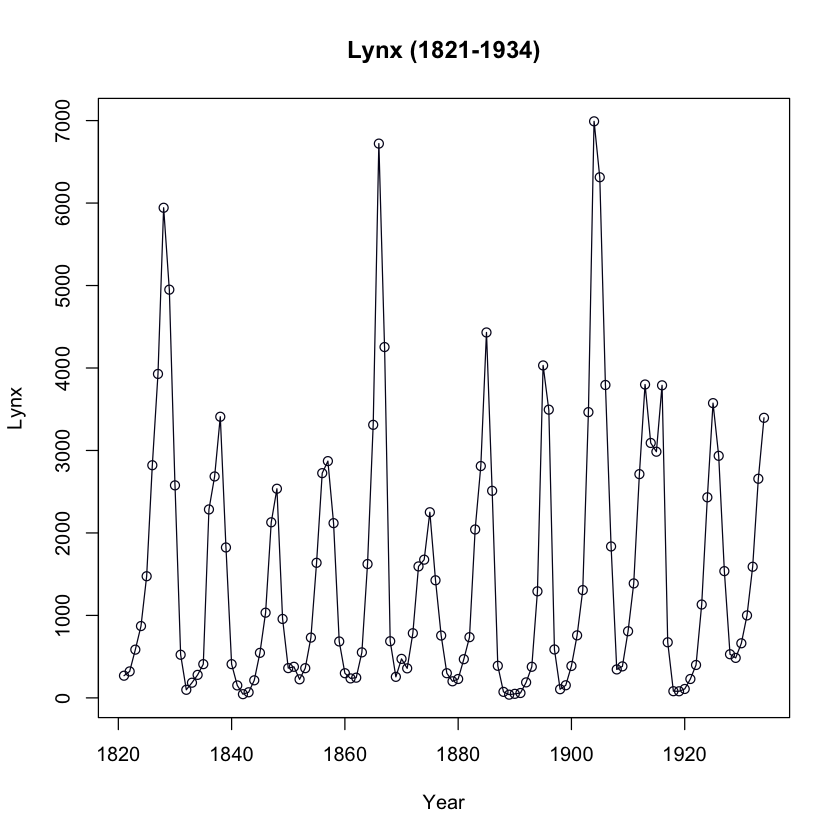

In [66]:
# Vẽ đồ thị chuỗi thời gian
plot(df$nam, df$lynx,
     type = "o", col = "#050521", xlab = "Year", ylab = "Lynx",
     main = "Lynx (1821-1934)"
)


### TÁCH TRAIN-TEST DATA


In [67]:
# Tạo tập huấn luyện từ năm 1821 đến 1920
train_data <- df[df$nam <= 1920, ]

# Tạo tập kiểm tra từ năm 1921 đến 1934
test_data <- df[df$nam >= 1921 & df$nam <= 1934, ]


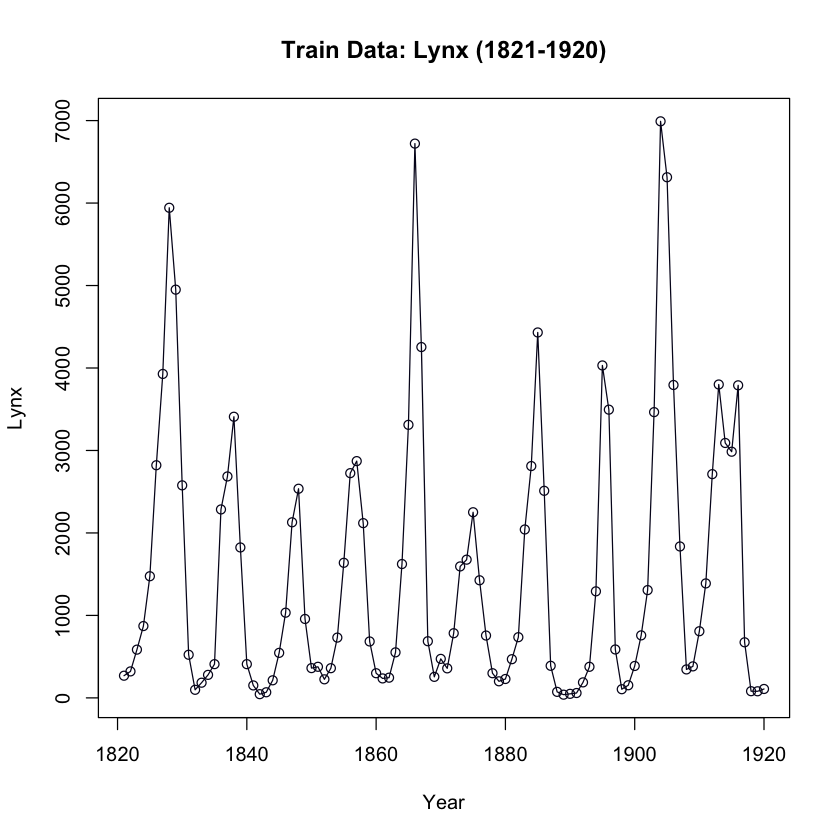

In [68]:
# Vẽ đồ thị chuỗi thời gian
plot(train_data$nam, train_data$lynx,
     type = "o", col = "#050521", xlab = "Year", ylab = "Lynx",
     main = "Train Data: Lynx (1821-1920)"
)


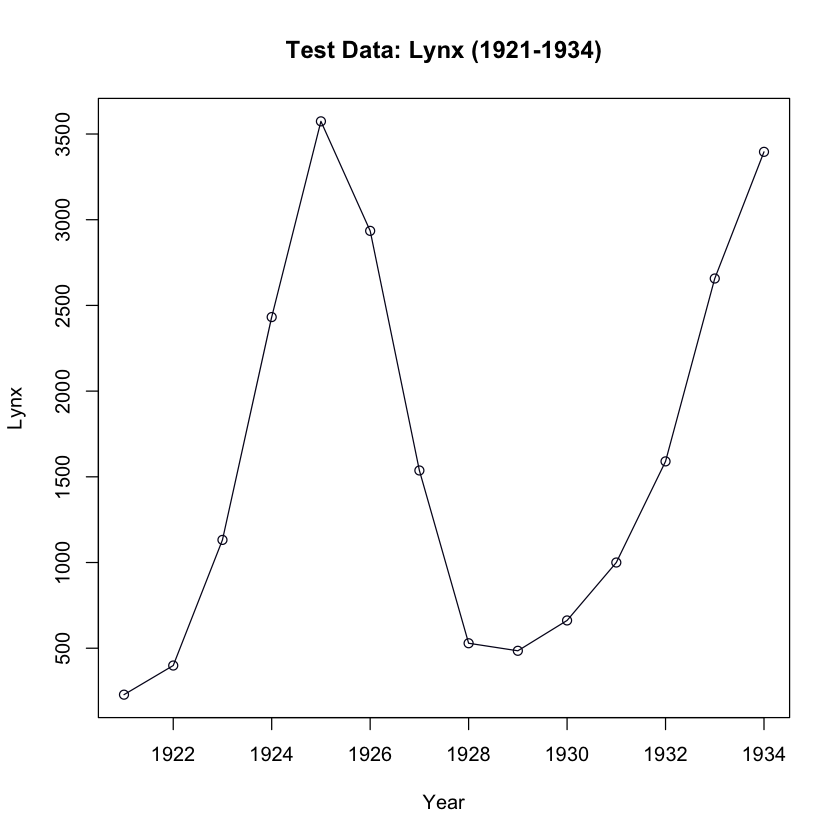

In [69]:
# Vẽ đồ thị chuỗi thời gian
plot(test_data$nam, test_data$lynx,
     type = "o", col = "#050521", xlab = "Year", ylab = "Lynx",
     main = "Test Data: Lynx (1921-1934)"
)


In [70]:
model <- ar(train_data$lynx, aic = FALSE, order.max = 1)
model



Call:
ar(x = train_data$lynx, aic = FALSE, order.max = 1)

Coefficients:
     1  
0.7112  

Order selected 1  sigma^2 estimated as  1342460

In [71]:
# Ước lượng hệ số:
ar_coefficient <- model$ar
ar_coefficient
# Phương sai
model$var.pred
# Trung bình chuỗi:
model$x.mean
# Thặng dư của mô hình
model$resid


[1] 0.7111969

[1] 1342460

[1] 1527.77

[1]          NA  -311.53672   -84.51896    13.72507   414.32276  1330.75986
  [7]  1480.48888  2708.19395   282.13228 -1384.64924 -1750.97908  -715.18073
 [13]  -326.92206  -293.08499  -230.64869  1552.89571   618.69040  1058.21165
 [19] -1041.69487 -1329.44785  -581.10429  -503.61550  -405.22863  -276.58616
 [25]   -46.70970   203.46174   953.10887   580.63711 -1287.82001  -760.84017
 [31]  -320.96684  -484.34599  -241.24406    33.74436   676.89032  1118.83477
 [37]   491.76378  -364.07096 -1264.25092  -628.68342  -417.87263  -364.06723
 [43]   -63.46800   789.19456  1715.50272  3925.00242  -967.17888 -2779.65622
 [49]  -674.81701  -149.57997  -419.62089    88.16675   595.19689   101.12743
 [55]   617.80929  -616.12891  -699.39150  -679.88960  -452.87263  -355.17534
 [61]  -135.08885   -38.77610  1077.33434   917.51124  1990.60085 -1081.53807
 [67] -1838.04009  -644.88035  -454.14214  -419.96145  -417.07342  -295.18538
 [73]  -197.92978   582.65401  2670.90888   186.94068 -2339.85780  -753.69733
 [79]  -362.90044  -163.03789    41.54205   326.68801  2094.24093  4085.47810
 [85]   899.79796 -1137.01056 -1303.50567 -1401.98221  -304.58769    95.09803
 [91]   372.12817  1284.63399  1429.29814   -52.77285   345.46573  1225.85260
 [97] -2462.66088  -839.57145  -418.83171  -390.12052

### DỰ ĐOÁN GIÁ TRỊ TỪ 1921 ĐẾN 1934


In [72]:
# Dự đoán giá trị lynx từ năm 1921 đến năm 1934
lynx_prediction <- predict(model, n.ahead = 14, se.fit = FALSE)
test_data$predict_lynx <- lynx_prediction
test_data


,nam,lynx,predict_lynx
,<int>,<dbl>,<ts>
101,1921,229,518.0340
102,1922,399,809.6489
103,1923,1132,1017.0446
104,1924,2432,1164.5437
105,1925,3574,1269.4446
106,1926,2935,1344.0498
107,1927,1537,1397.1087
108,1928,529,1434.8441
109,1929,485,1461.6814


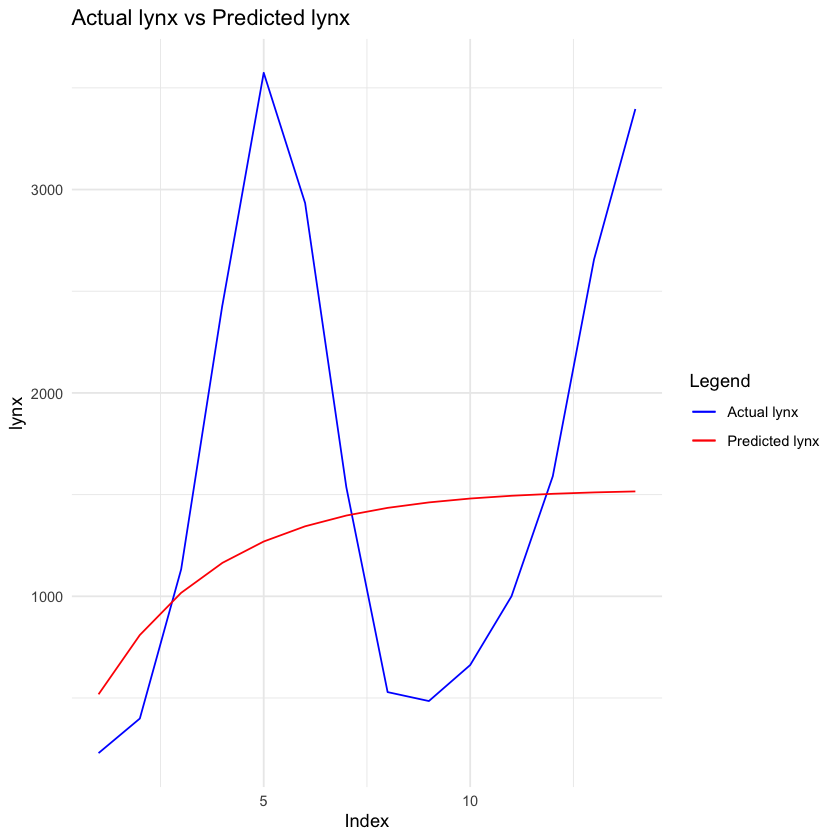

In [73]:
# Plotting
# Plotting with legend
ggplot(test_data, aes(x = 1:nrow(test_data))) +
     geom_line(aes(y = lynx, color = "Actual lynx")) +
     geom_line(aes(y = lynx_prediction, color = "Predicted lynx")) +
     labs(
          title = "Actual lynx vs Predicted lynx",
          x = "Index",
          y = "lynx",
          color = "Legend"
     ) + # Adding legend title
     scale_color_manual(values = c("Actual lynx" = "blue", "Predicted lynx" = "red")) +
     theme_minimal()


- Giá trị dự đoán và giá trị thực tế chênh lệch nhau rất nhiều


### CÂU B


In [74]:
lynx_model_ar1 <- list(order = c(1, 0, 0), ar = model$ar)
lynx_resid_ar1 <- model$resid[!is.na(model$resid)]
lynx_resid_ar1 <- lynx_resid_ar1 - mean(lynx_resid_ar1)


In [75]:
lynx_fun_ar <- function(tsb, order) {
    ar_fit <- ar(tsb, order.max = order)
    res_pred <- predict(ar_fit, n.ahead = 14, se.fit = FALSE)
    return(c(ar_fit$ar, res_pred))
}


In [76]:
lynx_sim <- function(tsresid, n.sim, ran.args) {
    # random generation of replicate series using arima.sim
    rg1 <- function(n, tsresid) sample(tsresid, n, replace = TRUE)
    ts_orig <- ran.args$ts
    ts_mod <- ran.args$model
    new_ts <- arima.sim(
        model = ts_mod, n = n.sim, rand.gen = rg1,
        tsresid = as.vector(tsresid)
    )
    new_ts <- new_ts + mean(ts_orig)
    return(new_ts)
}


In [77]:
set.seed(147)
out_mb_lynx_ar1 <- tsboot(
    tseries = lynx_resid_ar1, statistic = lynx_fun_ar,
    R = 5000, sim = "model", n.sim = 100, orig.t = FALSE,
    ran.gen = lynx_sim,
    ran.args = list(
        ts = lynx[1:100],
        model = lynx_model_ar1
    ),
    order = 1
)
out_mb_lynx_ar1



MODEL BASED BOOTSTRAP FOR TIME SERIES


Call:
tsboot(tseries = lynx_resid_ar1, statistic = lynx_fun_ar, R = 5000, 
    sim = "model", n.sim = 100, orig.t = FALSE, ran.gen = lynx_sim, 
    ran.args = list(ts = lynx[1:100], model = lynx_model_ar1), 
    order = 1)


Bootstrap Statistics :
             mean   std. error
t1*     0.6711379 7.342872e-02
t2*  1536.1798028 1.104107e+03
t3*  1529.4264586 7.944518e+02
t4*  1526.2497675 6.080225e+02
t5*  1524.9682962 5.000026e+02
t6*  1524.6557380 4.405046e+02
t7*  1524.8085550 4.093175e+02
t8*  1525.1582350 3.936329e+02
t9*  1525.5659430 3.860344e+02
t10* 1525.9636576 3.825213e+02
t11* 1526.3214062 3.810248e+02
t12* 1526.6291194 3.804989e+02
t13* 1526.8866634 3.804211e+02
t14* 1527.0984408 3.805342e+02
t15* 1527.2705327 3.807138e+02

In [78]:
ci_out_mb_lynx_ar1 <- apply(
    out_mb_lynx_ar1$t[, 2:15], 2,
    function(x) quantile(x, c(0.025, 0.975))
)
ci_out_mb_lynx_ar1


2.5%,-420.8483,61.98979,381.6157,579.938,691.994,743.5471,772.5032,777.9644,782.7106,775.4918,774.1933,773.1949,773.1945,772.7097
97.5%,3984.1680,3263.00498,2843.8436,2567.189,2415.681,2343.2210,2302.5819,2284.1720,2282.1621,2273.2251,2273.7271,2274.7199,2272.7858,2272.5056


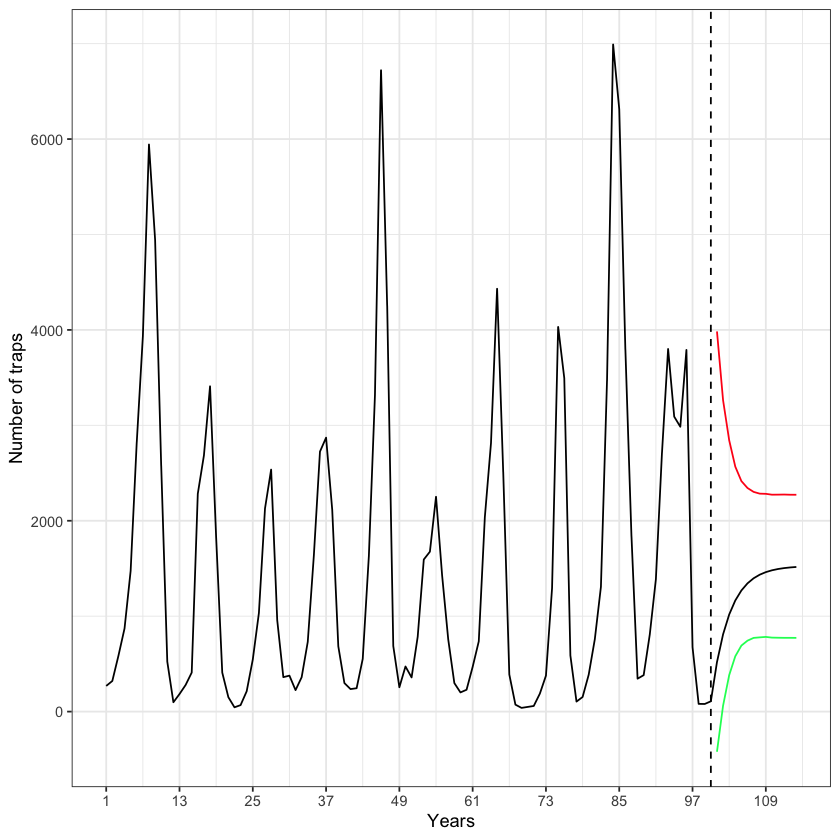

In [79]:
data <- data.frame(
     id = c(1:114),
     y = c(as.numeric(train_data$lynx), test_data$predict_lynx)
)

ggplot(
     data = data,
     mapping = aes(x = id, y = y)
) +
     geom_line() +
     geom_vline(xintercept = 100, linetype = "dashed") +
     geom_line(
          mapping = aes(x = x, y = y),
          data = data.frame(x = c(101:114), y = ci_out_mb_lynx_ar1[1, ]),
          color = "#00ff62"
     ) +
     geom_line(
          mapping = aes(x = x, y = y),
          data = data.frame(x = c(101:114), y = ci_out_mb_lynx_ar1[2, ]),
          color = "#ff0019"
     ) +
     labs(x = "Years", y = "Number of traps") +
     scale_x_continuous(
          breaks = seq(1, 114, by = 12),
          labels = as.character(seq(start(train_data$lynx)[1], end(train_data$lynx)[1] + 14, by = 12))
     ) +
     theme_bw()


## BÀI TẬP 7


### CÂU A


In [80]:
model <- ar(train_data$lynx, aic = FALSE, order.max = 25)
model



Call:
ar(x = train_data$lynx, aic = FALSE, order.max = 25)

Coefficients:
      1        2        3        4        5        6        7        8  
 1.0180  -0.5811   0.2360  -0.2361   0.1072  -0.0724  -0.1559   0.2413  
      9       10       11       12       13       14       15       16  
-0.0148   0.0782  -0.1916   0.1659  -0.2339   0.1218  -0.0613  -0.0044  
     17       18       19       20       21       22       23       24  
-0.0752   0.0009   0.1359  -0.1830   0.0747  -0.0896   0.0953  -0.1098  
     25  
 0.0195  

Order selected 25  sigma^2 estimated as  893764

In [81]:
# Dự đoán giá trị lynx từ năm 1921 đến năm 1934
lynx_prediction <- predict(model, n.ahead = 14, se.fit = FALSE)
test_data$predict_lynx <- lynx_prediction
test_data


,nam,lynx,predict_lynx
,<int>,<dbl>,<ts>
101,1921,229,1044.60038
102,1922,399,1816.99019
103,1923,1132,2308.09150
104,1924,2432,2704.82473
105,1925,3574,2136.67384
106,1926,2935,1075.16711
107,1927,1537,226.64736
108,1928,529,64.17695
109,1929,485,-259.00531


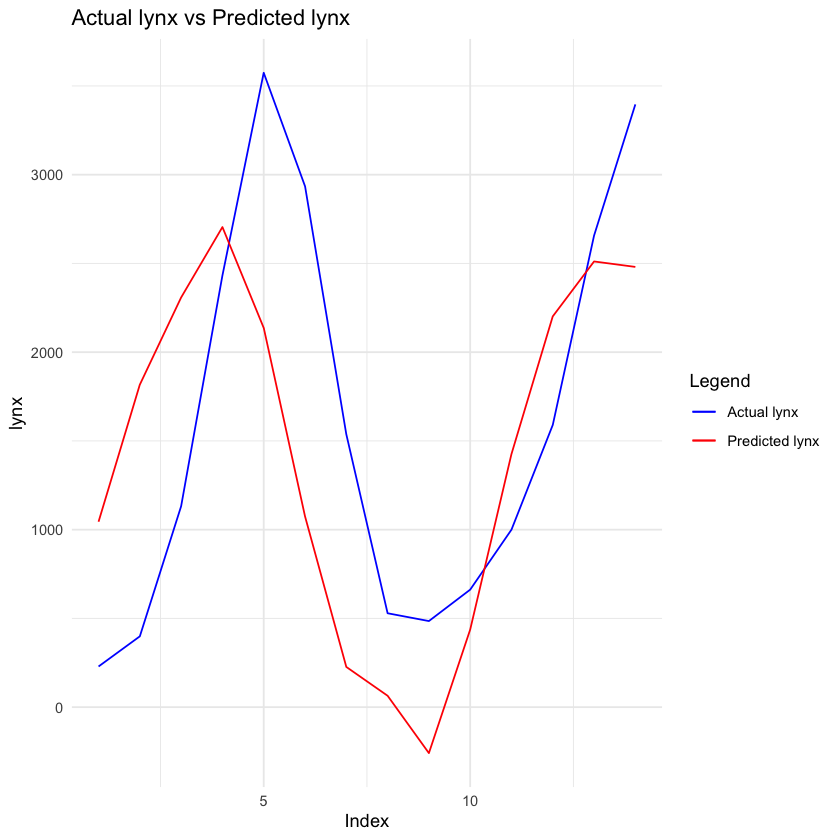

In [82]:
# Plotting
# Plotting with legend
ggplot(test_data, aes(x = 1:nrow(test_data))) +
     geom_line(aes(y = lynx, color = "Actual lynx")) +
     geom_line(aes(y = lynx_prediction, color = "Predicted lynx")) +
     labs(
          title = "Actual lynx vs Predicted lynx",
          x = "Index",
          y = "lynx",
          color = "Legend"
     ) + # Adding legend title
     scale_color_manual(values = c("Actual lynx" = "blue", "Predicted lynx" = "red")) +
     theme_minimal()


### CÂU B


In [89]:
lynx_model_ar1 <- list(order = c(25, 0, 0), ar = model$ar)
lynx_resid_ar1 <- model$resid[!is.na(model$resid)]
lynx_resid_ar1 <- lynx_resid_ar1 - mean(lynx_resid_ar1)


In [90]:
lynx_fun_ar <- function(tsb) {
    ar_fit <- ar(tsb, order.max = 25, aic = FALSE)
    res_pred <- predict(ar_fit, n.ahead = 14, se.fit = FALSE)
    return(c(ar_fit$ar, res_pred))
}


In [91]:
lynx_sim <- function(tsresid, n.sim, ran.args) {
    # random generation of replicate series using arima.sim
    rg1 <- function(n, tsresid) sample(tsresid, n, replace = TRUE)
    ts_orig <- ran.args$ts
    ts_mod <- ran.args$model
    new_ts <- arima.sim(
        model = ts_mod, n = n.sim, rand.gen = rg1,
        tsresid = as.vector(tsresid)
    )
    new_ts <- new_ts + mean(ts_orig)
    return(new_ts)
}


In [92]:
set.seed(147)
out_mb_lynx_ar1 <- tsboot(
    tseries = lynx_resid_ar1, statistic = lynx_fun_ar,
    R = 5000, sim = "model", n.sim = length(lynx[1:100]), orig.t = FALSE,
    ran.gen = lynx_sim,
    ran.args = list(
        ts = lynx[1:100],
        model = lynx_model_ar1
    ),
    # order = 25
)
out_mb_lynx_ar1



MODEL BASED BOOTSTRAP FOR TIME SERIES


Call:
tsboot(tseries = lynx_resid_ar1, statistic = lynx_fun_ar, R = 5000, 
    sim = "model", n.sim = length(lynx[1:100]), orig.t = FALSE, 
    ran.gen = lynx_sim, ran.args = list(ts = lynx[1:100], model = lynx_model_ar1))


Bootstrap Statistics :
              mean   std. error
t1*   8.063408e-01 5.603573e-02
t2*  -4.552671e-03 4.657739e-02
t3*  -1.483149e-03 1.693661e-02
t4*  -1.617099e-03 7.923628e-03
t5*  -1.099685e-03 4.207374e-03
t6*  -1.014304e-03 2.581338e-03
t7*  -8.195140e-04 1.975092e-03
t8*  -7.332832e-04 1.714014e-03
t9*  -6.365267e-04 1.588050e-03
t10* -5.765053e-04 1.491595e-03
t11* -5.232004e-04 1.410038e-03
t12* -4.861764e-04 1.331764e-03
t13* -4.567201e-04 1.256890e-03
t14* -4.360086e-04 1.183646e-03
t15* -4.209344e-04 1.112229e-03
t16* -4.109958e-04 1.042187e-03
t17* -4.047906e-04 9.734909e-04
t18* -4.016055e-04 9.059635e-04
t19* -4.007328e-04 8.394908e-04
t20* -4.013801e-04 7.740640e-04
t21* -4.034494e-04 7.094441e-04
t22* -4

In [93]:
ci_out_mb_lynx_ar1 <- apply(
    out_mb_lynx_ar1$t[, 2:15], 2,
    function(x) quantile(x, c(0.025, 0.975))
)
ci_out_mb_lynx_ar1


2.5%,-0.008321712,-0.006083026,-0.0050520456,-0.0037574276,-0.0031485476,-0.0021320945,-0.001660952,-0.0012258664,-0.0009774608,-0.0007565229,-0.0006096742,-0.0005239497,-0.0004748286,-0.0004408082
97.5%,-0.001302663,-0.001087637,-0.0009168258,-0.0007711383,-0.0006571502,-0.0005657236,-0.000495438,-0.0004406591,-0.0003991322,-0.0003683329,-0.0003466886,-0.0003326570,-0.0003244613,-0.0003209388


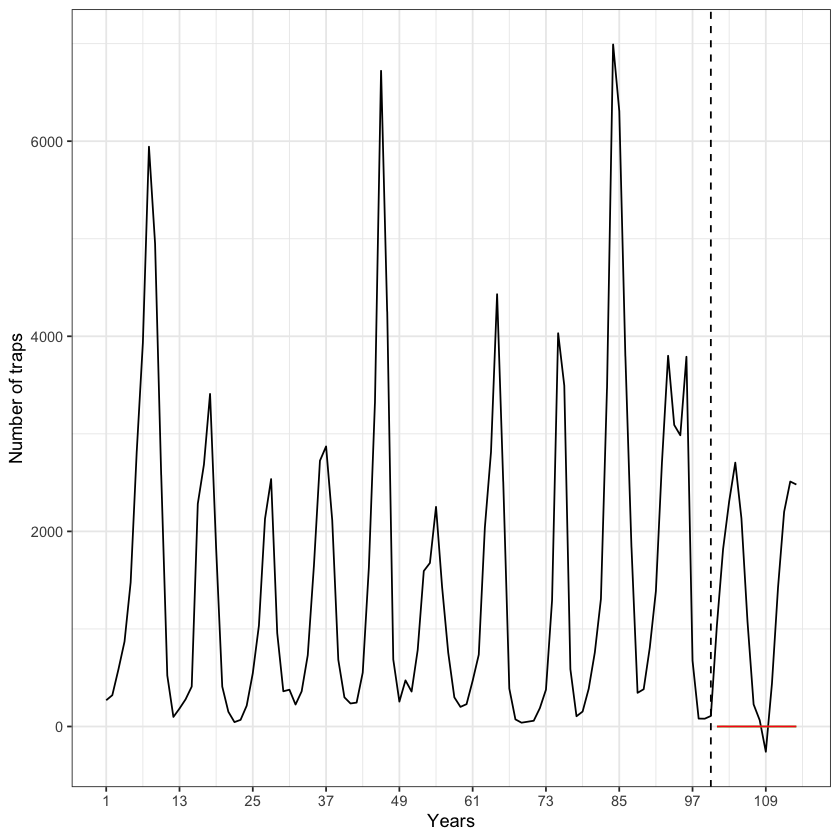

In [88]:
data <- data.frame(
     id = c(1:114),
     y = c(as.numeric(train_data$lynx), test_data$predict_lynx)
)

ggplot(
     data = data,
     mapping = aes(x = id, y = y)
) +
     geom_line() +
     geom_vline(xintercept = 100, linetype = "dashed") +
     geom_line(
          mapping = aes(x = x, y = y),
          data = data.frame(x = c(101:114), y = ci_out_mb_lynx_ar1[1, ]),
          color = "#00ff62"
     ) +
     geom_line(
          mapping = aes(x = x, y = y),
          data = data.frame(x = c(101:114), y = ci_out_mb_lynx_ar1[2, ]),
          color = "#ff0019"
     ) +
     labs(x = "Years", y = "Number of traps") +
     scale_x_continuous(
          breaks = seq(1, 114, by = 12),
          labels = as.character(seq(start(train_data$lynx)[1], end(train_data$lynx)[1] + 14, by = 12))
     ) +
     theme_bw()
